In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from src.pca import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [2]:
mnist = fetch_openml('mnist_784', version=1) # load MNIST from OpenML

In [3]:
X, y = mnist.data / 255., mnist.target.astype(int) # scale images pixels to [0,1] range and cast labels to int

X = X.to_numpy()
y = y.to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
del X, y, mnist
print(X_train.shape, X_test.shape)

(56000, 784) (14000, 784)


In [5]:
n_components_list = [1, 10, 50, 100]

In [6]:
X_train_pca: dict[int, np.ndarray] = {}
X_train_reconstructed: dict[int, np.ndarray] = {}
X_test_pca: dict[int, np.ndarray] = {}
pca_explained_variance: dict[int, float] = {}

Fit PCA with each specified number of components

In [7]:
for n_components in n_components_list:
    pca = PCA(n_components)
    pca.fit(X_train)

    X_train_pca[n_components] = pca.transform(X_train)
    X_train_reconstructed[n_components] = pca.inverse_transform(X_train_pca[n_components])

    X_test_pca[n_components] = pca.transform(X_test)
    
    pca_explained_variance[n_components] = pca.explained_variance_ratio_.sum()
    
    print(f'Explained variance with {n_components} PC: {pca_explained_variance[n_components]:.2f}')
del pca

Explained variance with 1 PC: 0.06
Explained variance with 10 PC: 0.28
Explained variance with 50 PC: 0.55
Explained variance with 100 PC: 0.71


## Compression

In [8]:
each_digit_indices = [np.argwhere(y_train == digit).ravel()[0] for digit in range(10)]

Visualize original and reconstructed digits

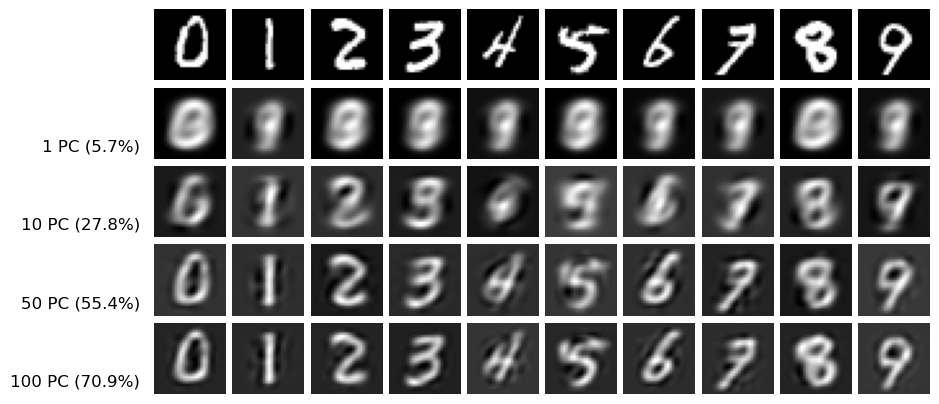

In [10]:
fig, axes = plt.subplots(len(n_components_list) + 1, 10, figsize=(10, 1 + len(n_components_list)))
for i, digit_i in enumerate(each_digit_indices):
    axes[0, i].imshow(X_train[digit_i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    for j, n_components in enumerate(n_components_list):
        axes[j + 1, i].imshow(X_train_reconstructed[n_components][digit_i].reshape(28, 28), cmap='gray')
        axes[j + 1, i].axis('off')

        if i == 0:
            axes[j + 1, i].set_title(f'{n_components} PC ({pca_explained_variance[n_components] * 100:.1f}%)', 
                                     rotation='horizontal', x=-.2, y=0, loc='right')

plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig('../../resources/pca/mnist_compression_demo.png', transparent=True, bbox_inches='tight')

## MLP inference

In [10]:
class MLP(nn.Module): # simple feedforward neural network
    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super(MLP, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_stack(x)


In [11]:
train_datasets_pca: dict[int, TensorDataset] = {}
test_datasets_pca: dict[int, TensorDataset] = {}

Prepare datasets for training and testing on different components amount

In [12]:
for n_components in n_components_list:
    train_dataset = TensorDataset(torch.tensor(X_train_pca[n_components], dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test_pca[n_components], dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.long))

    train_datasets_pca[n_components] = train_dataset
    test_datasets_pca[n_components] = test_dataset
del X_train_pca, X_test_pca

In [13]:
orig_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
orig_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

In [14]:
def train_loop(model: MLP,
               train_loader_: DataLoader,
               *,
               num_epochs: int = 100,
               learning_rate: float = 1e-2,
               criterion: nn.Module | None = None,
               optimizer: optim.Optimizer | None = None,
               device: torch.device) -> None:
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for _ in tqdm(range(num_epochs)):
        for X_batch, y_batch in train_loader_:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

In [15]:
def test_loop(model: MLP, test_loader_: DataLoader, *, device: torch.device) -> float:
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader_:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    return correct / total

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
hidden_size = 128
num_classes = 10

batch_size = 128
num_epochs = 100

Train on dimension-reduced or original data

Check accuracy on test set for each number of components

In [18]:
accuracy_list = []
for n_components in n_components_list + [None]:
    train_loader = DataLoader(train_datasets_pca.get(n_components, orig_train_dataset),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_datasets_pca.get(n_components, orig_test_dataset),
                             batch_size=batch_size, shuffle=False)
    n_components = n_components or X_train.shape[1]
    model = MLP(n_components, hidden_size, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loop(model, train_loader, num_epochs=100, optimizer=optimizer, device=device)
    accuracy = test_loop(model, test_loader, device=device)
    accuracy_list.append(accuracy)
    print(f'Accuracy with {n_components} PC: {accuracy:.2f}')

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


Accuracy with 1 PC: 0.31


100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


Accuracy with 10 PC: 0.92


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Accuracy with 50 PC: 0.98


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


Accuracy with 100 PC: 0.97


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]

Accuracy with 784 PC: 0.98
